In [ ]:
pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import integrate
from math import pi, sqrt, exp
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
from scipy.optimize import minimize

# ***Defining the Dataset***

In [ ]:
def generate_data(n=5000, seed = 0, beta1=1.05, alpha1=0.4, alpha2=0.3):
    np.random.seed(seed)
    age = np.random.normal(65, 5, n)
    sodium = age / 18 + np.random.normal(size=n)
    bloodpressure = beta1 * sodium + 2 * age + np.random.normal(size=n)
    proteinuria = alpha1 * sodium + alpha2 * bloodpressure + np.random.normal(size=n)
    return pd.DataFrame({'bloodpressure': bloodpressure, 'sodium': sodium,
                         'age': age, 'proteinuria': proteinuria})

data = generate_data(n=5000, seed = 0, beta1=1.05, alpha1=0.4, alpha2=0.3)
data

,bloodpressure,sodium,age,proteinuria
0,152.069798,4.410849,73.820262,49.855261
1,136.302391,2.984810,67.000786,42.671658
2,143.984346,2.346063,69.893690,43.736376
3,156.454474,3.671327,76.204466,48.838422
4,151.154654,2.530366,74.337790,46.858840
...,...,...,...,...
4995,131.477051,1.773670,64.493128,40.424245
4996,143.359459,3.860877,68.733329,44.443191
4997,144.650306,4.386089,69.645909,45.092268
4998,135.537161,3.641918,66.147090,41.058984


# ***The DAG Representing the Relationship Between Variables***

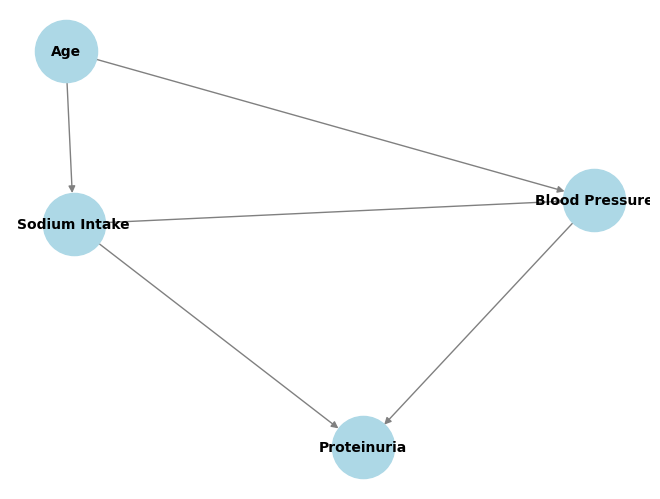

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a DAG
G = nx.DiGraph()

# Add nodes
G.add_node("Sodium Intake")
G.add_node("Blood Pressure")
G.add_node("Age")
G.add_node("Proteinuria")

# Add edges
G.add_edge("Sodium Intake", "Blood Pressure")
G.add_edge("Age", "Blood Pressure")
G.add_edge("Age", "Sodium Intake")
G.add_edge("Blood Pressure", "Proteinuria")
G.add_edge("Sodium Intake", "Proteinuria")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()


In [ ]:
# Removing proteinuria from the dataset. This is because our target variable is blood pressure,
# and according to the aforementioned Directed Acyclic Graph (DAG), having values for age and sodium intake is sufficient.

data = data.drop('proteinuria', axis=1)

# Copying data.

Data = data.copy(deep=True)

In [ ]:
# Establishing the count of fuzzy subsets for each input and output variable

num_fuzzy_sets = 8
num_intervals  = num_fuzzy_sets -1

# The hyperparameter c is associated with the standard deviation of the Gaussian fuzzy subsets mentioned previously.

c = 0.2

# Partitioning the domain of each variable to define gaussian fuzzy sets
# Here, 'variable' is a column of our dataset such as data['column']

def partition(variable, i):
  min = variable.min()
  max = variable.max()
  return  min + i*(max - min)/num_intervals

# Defining the membership degree of the ith fuzzy subset of variable at x

def membership_function(variable, i, x):
  if i == 0:
    point_1 = partition(variable, i)
    point_2 = partition(variable, i + 1)
    mean = point_1
    std = c*(point_2 - point_1)
    return np.where(point_1 <= x, np.exp(-((x - mean)**2)/(2*(std**2))), 1)
  elif i == num_intervals:
    point_1 = partition(variable, i - 1)
    point_2 = partition(variable, i )
    mean = point_2
    std = c*(point_2 - point_1)
    return np.where(x <= point_2, np.exp(-((x - mean)**2)/(2*(std**2))), 1)
  else:
    point_1 = partition(variable, i - 1)
    point_2 = partition(variable, i)
    point_3 = partition(variable, i + 1)
    mean = point_2
    std = c*(point_3 - point_2)
    return np.exp(-((x - mean)**2)/(2*(std**2)))

# ***Defining the Membership Functions***

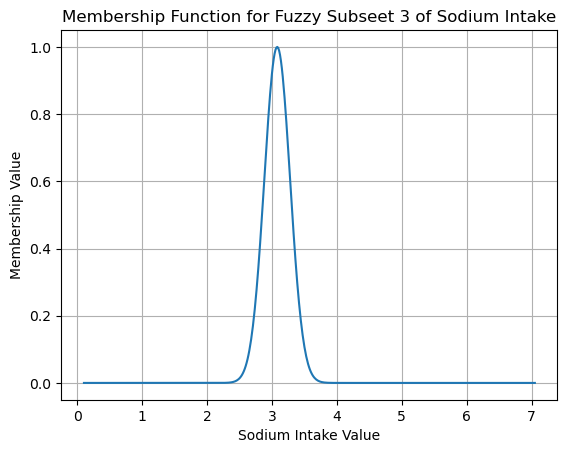

In [ ]:
# Generate a range of x values
x_values = np.linspace(data['sodium'].min(), data['sodium'].max(), 500)

# Select the fuzzy set index i to plot
i = 3  # For example, plot the membership function for the third fuzzy set

# Compute membership values
membership_values = membership_function(data['sodium'], i, x_values)

# Plotting
plt.plot(x_values, membership_values)
plt.title(f'Membership Function for Fuzzy Subseet {i} of Sodium Intake')
plt.xlabel('Sodium Intake Value')
plt.ylabel('Membership Value')
plt.grid(True)
plt.show()

# ***Substituting our Crisp Dataset to a Fuzzy Dataset***

In [ ]:
# Substituting each value in our dataset with the index of a fuzzy subset from the set {0, 1, ..., num_fuzzy_sets - 1}
# that best represents the value compared to the other fuzzy subsets.

def apply_and_replace(variable, x):
    max_result = -float('inf')  # Initialize with negative infinity
    max_index = -1  # Initialize index
    for i in range(num_fuzzy_sets):
        result = membership_function(variable, i, x)
        if result > max_result:
            max_result = result
            max_index = i
    return max_index

df = Data.to_numpy()

Data['bloodpressure'] = Data['bloodpressure'].apply(lambda x: apply_and_replace(Data['bloodpressure'], x))
Data['sodium'] = Data['sodium'].apply(lambda x: apply_and_replace(Data['sodium'], x))
Data['age'] = Data['age'].apply(lambda x: apply_and_replace(Data['age'], x))
Data

,bloodpressure,sodium,age
0,5,4,5
1,4,3,4
2,4,2,4
3,5,4,6
4,5,2,5
...,...,...,...
4995,3,2,3
4996,4,4,4
4997,4,4,4
4998,4,4,4


# ***Extracting Fuzzy Rules***

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Encode categorical data (convert to binary format)
data_encoded = pd.get_dummies(Data, columns=['bloodpressure', 'sodium', 'age'])

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(data_encoded, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# List of all blood pressure related items
levels = list(np.arange(1, num_fuzzy_sets))
bloodpressure_items = [f'bloodpressure_{level}' for level in levels]

# Filter rules where all items in the consequents are blood pressure related
bloodpressure_only_rules = rules[rules['consequents'].apply(lambda x: all(item in bloodpressure_items for item in x))]
rules_with_one_element = bloodpressure_only_rules[bloodpressure_only_rules['antecedents'].apply(lambda x: len(x) == 1)]
rules_with_two_elements = bloodpressure_only_rules[bloodpressure_only_rules['antecedents'].apply(lambda x: len(x) == 2)]

def transform_item(item):
    # Split the item into parts and handle cases with more than one underscore
    parts = item.split('_')
    if len(parts) > 2:
        # Rejoin all parts except the last as the variable name
        variable = '_'.join(parts[:-1])
        value = parts[-1]
    else:
        variable, value = parts

    # Return the transformed item as a normal text string
    return f"{variable}['{value}']"

def transform_rule_set(rule_set):
    # Transform each item in the set
    return set(transform_item(item) for item in rule_set)

# Apply the transformation to your filtered rules
for d in [rules_with_one_element, rules_with_two_elements]:
    d['antecedents'] = d['antecedents'].apply(transform_rule_set)
    d['consequents'] = d['consequents'].apply(transform_rule_set)

# Extracting an example
antecedents = list(rules_with_two_elements.iloc[0]['antecedents'])
consequents = list(rules_with_two_elements.iloc[0]['consequents'])

# First antecedent as a normal text string
antecedent_text = antecedents[0]
print(antecedent_text)
type(antecedent_text)

sodium['2']


/tmp/ipykernel_748647/2771151615.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['antecedents'] = d['antecedents'].apply(transform_rule_set)
/tmp/ipykernel_748647/2771151615.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['consequents'] = d['consequents'].apply(transform_rule_set)


str

In [ ]:
rules_with_two_elements

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
52,"{sodium['2'], age['2']}",{bloodpressure['2']},0.0276,0.1514,0.0246,0.891304,5.887083,0.020421,7.807120,0.853699
57,"{sodium['2'], age['3']}",{bloodpressure['2']},0.0612,0.1514,0.0100,0.163399,1.079252,0.000734,1.014342,0.078219
62,"{sodium['3'], age['2']}",{bloodpressure['2']},0.0534,0.1514,0.0524,0.981273,6.481330,0.044315,45.315240,0.893419
69,"{age['2'], sodium['4']}",{bloodpressure['2']},0.0374,0.1514,0.0342,0.914439,6.039884,0.028538,9.918012,0.866854
73,"{sodium['2'], age['3']}",{bloodpressure['3']},0.0612,0.3800,0.0512,0.836601,2.201582,0.027944,3.794400,0.581361
81,"{age['3'], sodium['3']}",{bloodpressure['3']},0.1372,0.3800,0.1262,0.919825,2.420592,0.074064,7.733091,0.680202
88,"{age['3'], sodium['4']}",{bloodpressure['3']},0.1148,0.3800,0.1060,0.923345,2.429855,0.062376,8.088182,0.664768
92,"{sodium['5'], age['3']}",{bloodpressure['3']},0.0428,0.3800,0.0376,0.878505,2.311854,0.021336,5.103077,0.592819
97,"{age['4'], sodium['2']}",{bloodpressure['4']},0.0366,0.3364,0.0250,0.683060,2.030500,0.012688,2.093772,0.526791
101,"{age['4'], sodium['3']}",{bloodpressure['4']},0.1074,0.3364,0.0904,0.841713,2.502120,0.054271,4.192391,0.672573


# ***Establishing the Fuzzy Control System***

In [ ]:
# Identifying the range of variables and methods for discretization

min_sodium = data['sodium'].min()
min_age = data['age'].min()
min_bloodpressure = data['bloodpressure'].min()

max_sodium = data['sodium'].max()
max_age = data['age'].max()
max_bloodpressure = data['bloodpressure'].max()

num_points = 1000
step_sodium = (max_sodium - min_sodium)/num_points
step_age = (max_age - min_age)/num_points
step_bloodpressure = (max_bloodpressure - min_bloodpressure)/num_points

# Establishing the antecedent and consequent in our fuzzy control system

sodium = ctrl.Antecedent(np.arange(min_sodium, max_sodium  , step_sodium), 'sodium')
age = ctrl.Antecedent(np.arange(min_age, max_age  , step_age), 'age')
bloodpressure = ctrl.Consequent(np.arange(min_bloodpressure, max_bloodpressure  , step_bloodpressure), 'bloodpressure', defuzzify_method = 'centroid' )

# Establishing the fuzzy subsets of variables

c = 0.2

#sodium
for i in range(num_fuzzy_sets):
  string = str(i)
  if i == 0:
    point_1 = partition(data['sodium'], i)
    point_2 = partition(data['sodium'], i + 1)
    sodium[string] = fuzz.gaussmf(sodium.universe, point_1, c*(point_2 - point_1))
  elif i == num_intervals:
    point_1 = partition(data['sodium'], i - 1)
    point_2 = partition(data['sodium'], i )
    sodium[string] = fuzz.gaussmf(sodium.universe, point_2, c*(point_2 - point_1))
  else:
    point_1 = partition(data['sodium'], i - 1)
    point_2 = partition(data['sodium'], i)
    point_3 = partition(data['sodium'], i + 1)
    sodium[string] = fuzz.gaussmf(sodium.universe, point_2, c*(point_3 - point_2))

#age
for i in range(num_fuzzy_sets):
  string = str(i)
  if i == 0:
    point_1 = partition(data['age'], i)
    point_2 = partition(data['age'], i + 1)
    age[string] = fuzz.gaussmf(age.universe, point_1, c*(point_2 - point_1))
  elif i == num_intervals:
    point_1 = partition(data['age'], i - 1)
    point_2 = partition(data['age'], i )
    age[string] = fuzz.gaussmf(age.universe, point_2, c*(point_2 - point_1))
  else:
    point_1 = partition(data['age'], i - 1)
    point_2 = partition(data['age'], i)
    point_3 = partition(data['age'], i + 1)
    age[string] = fuzz.gaussmf(age.universe, point_2, c*(point_3 - point_1))

#bloodpressure
for i in range(num_fuzzy_sets):
  string = str(i)
  if i == 0:
    point_1 = partition(data['bloodpressure'], i)
    point_2 = partition(data['bloodpressure'], i + 1)
    bloodpressure[string] = fuzz.gaussmf(bloodpressure.universe, point_1, c*(point_2 - point_1))
  elif i == num_intervals:
    point_1 = partition(data['bloodpressure'], i - 1)
    point_2 = partition(data['bloodpressure'], i )
    bloodpressure[string] = fuzz.gaussmf(bloodpressure.universe, point_2, c*(point_2 - point_1))
  else:
    point_1 = partition(data['bloodpressure'], i - 1)
    point_2 = partition(data['bloodpressure'], i)
    point_3 = partition(data['bloodpressure'], i + 1)
    bloodpressure[string] = fuzz.gaussmf(bloodpressure.universe, point_2, c*(point_3 - point_2))

# Establishing the rules

def parse_fuzzy_reference(reference_str, namespace):
    parts = reference_str.split('[')
    var_name = parts[0]
    # Correctly strip quotes and extra characters
    set_name = parts[1].replace("'", "").replace('"', "").replace("]", "")
    return namespace[var_name][set_name]


# Namespace for fuzzy variables
namespace = {'sodium': sodium, 'age': age, 'bloodpressure': bloodpressure}

# Function to combine conditions with AND
def combine_conditions(conditions):
    combined = conditions[0]
    for cond in conditions[1:]:
        combined &= cond
    return combined

# Define the fuzzy rules
fuzzy_rules = []

# For rules with one element
#for i in range(len(rules_with_one_element)):
 #   antecedents = list(rules_with_one_element.iloc[i]['antecedents'])
 #   consequents = list(rules_with_one_element.iloc[i]['consequents'])
 #   rule = ctrl.Rule(parse_fuzzy_reference(antecedents[0], namespace), parse_fuzzy_reference(consequents[0], namespace))
  #  fuzzy_rules.append(rule)

# For rules with two elements
for i in range(len(rules_with_two_elements)):
    antecedents = list(rules_with_two_elements.iloc[i]['antecedents'])
    consequents = list(rules_with_two_elements.iloc[i]['consequents'])
    antecedent_conditions = [parse_fuzzy_reference(ant, namespace) for ant in antecedents]
    rule = ctrl.Rule(combine_conditions(antecedent_conditions), parse_fuzzy_reference(consequents[0], namespace))
    fuzzy_rules.append(rule)

bloodpressure_ctrl = ctrl.ControlSystem(fuzzy_rules)
# Create a simulation
bloodpressure_simulation = ctrl.ControlSystemSimulation(bloodpressure_ctrl)

# Input values (food quality and service quality)
sodium_value = 4.410849
age_value = 73.820262

# Pass input values to the simulation
bloodpressure_simulation.input['sodium'] = sodium_value
bloodpressure_simulation.input['age'] = age_value
# Calculate the bloodpressure
bloodpressure_simulation.compute()

# Print the result
print("Estimated bloodpressure amount:", bloodpressure_simulation.output['bloodpressure'])

Estimated bloodpressure amount: 150.3756546110778


/opt/anaconda3/lib/python3.11/site-packages/skfuzzy/control/term.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


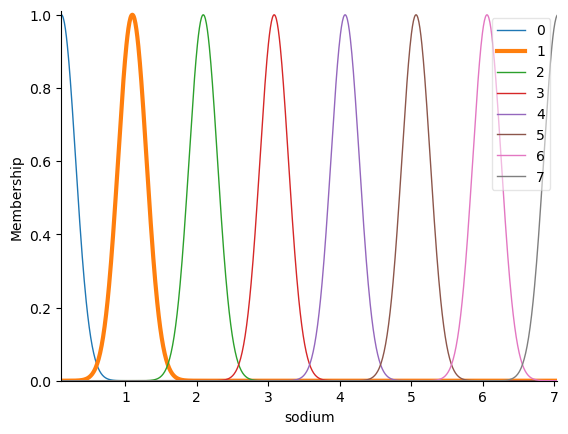

In [ ]:
sodium['1'].view()

# ***Predicted Output of our Fuzzy Control system***

In [ ]:
dff = data.copy(deep=True)
dff = dff.to_numpy()
ar = np.zeros(len(df))

for i in range(len(df)):
  sodium_value = dff[i][1]
  age_value = dff[i][2]
  bloodpressure_simulation.input['sodium'] = sodium_value
  bloodpressure_simulation.input['age'] = age_value
  bloodpressure_simulation.compute()
  ar[i] = bloodpressure_simulation.output['bloodpressure']

# ***Comparing Predicted Outputs with Actual Outputs***

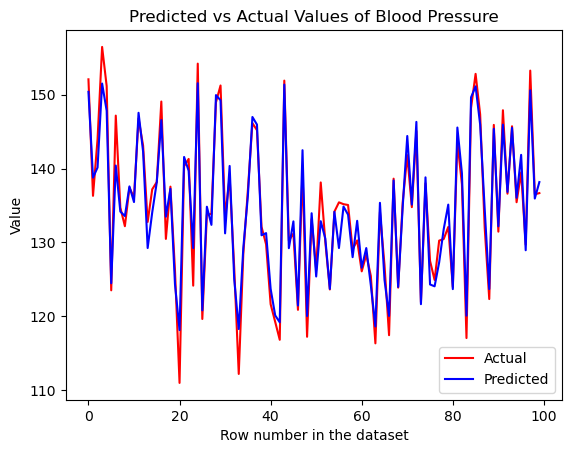

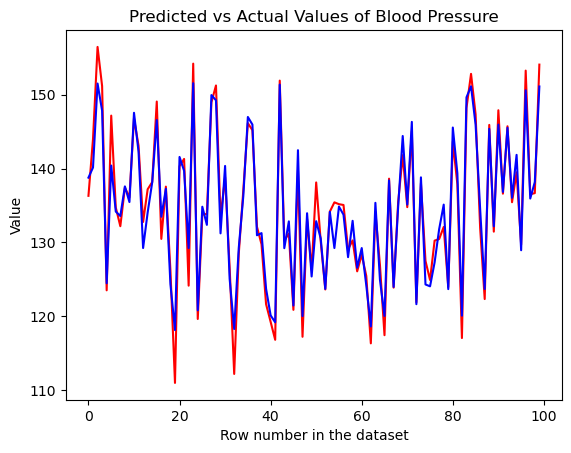

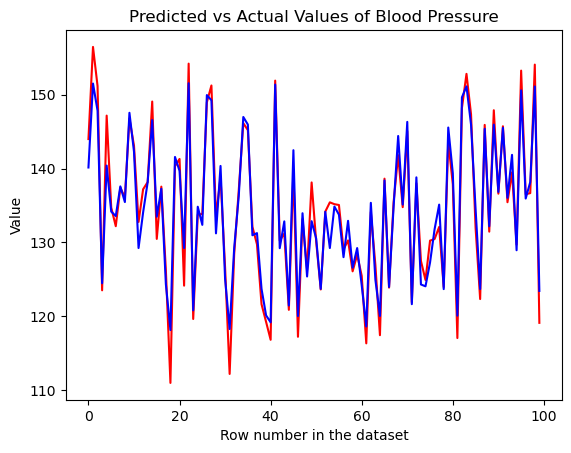

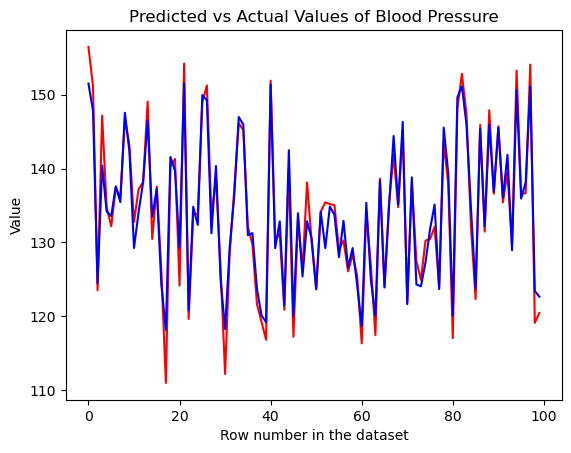

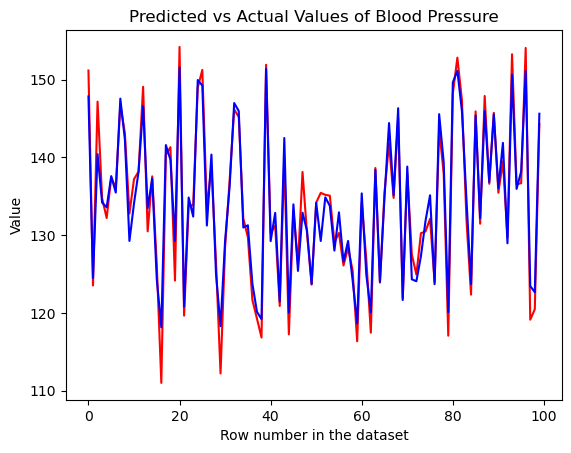

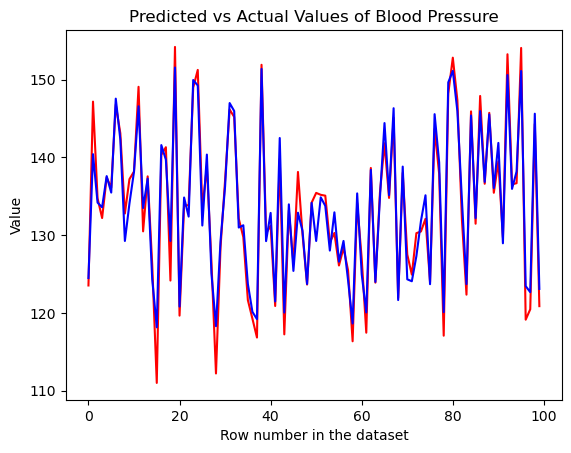

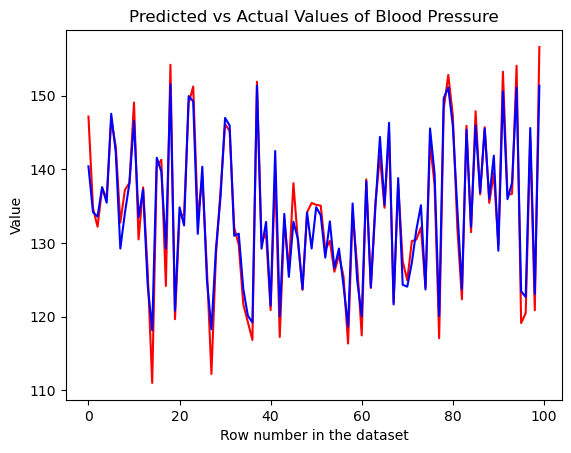

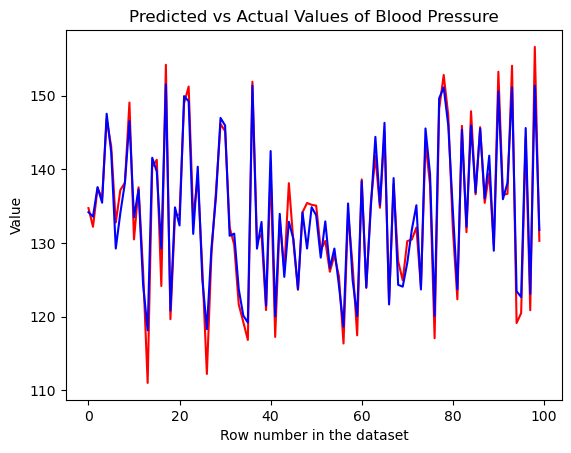

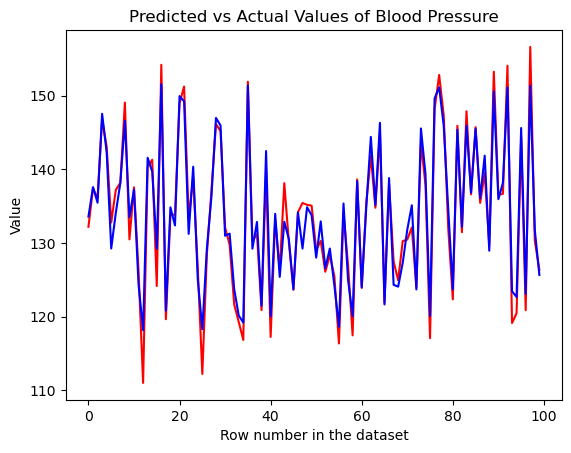

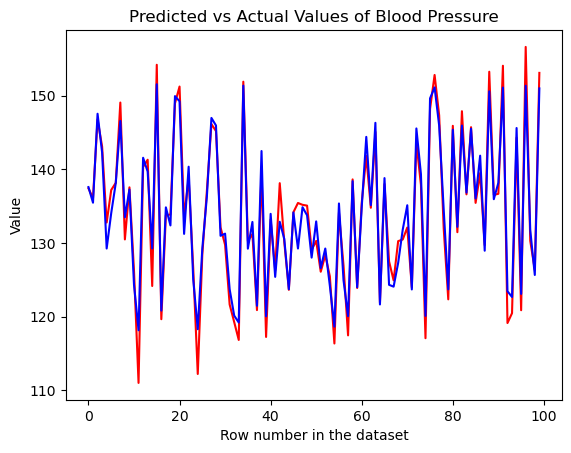

In [ ]:
for i in range(10):
    plt.plot(dff[i:i+100, 0], color='r', label='Actual' if i == 0 else "")
    plt.plot(ar[i:i+100], color='b', label='Predicted' if i == 0 else "")
    plt.title('Predicted vs Actual Values of Blood Pressure')
    plt.xlabel('Row number in the dataset')
    plt.ylabel('Value')
    if i == 0:
        plt.legend()
    plt.show()


# ***Implementing a Linear Regression Approach***

In [ ]:
# Define inputs and output
X = data[['sodium', 'age']]
y = ar

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print model coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)


Mean Squared Error: 10.544064014988344
Model Coefficients: [0.92263913 1.67138283]
Model Intercept: 22.066479778056205


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar

The linear regression model described previously results in a sinificantly big intercept. Therefore, we will adjust the model to not only minimize prediction errors but also reduce the magnitude of the intercept. To do so, we consider a hyperparameter $\lambda=0.4$ as the scale/coefficient of the absolute value of the intercept.


In [ ]:
X = data[['sodium', 'age']]
y = ar

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom loss function that includes the intercept term
def custom_loss_function(coefs, X, y, lambda_penalty):
    intercept, slopes = coefs[0], coefs[1:]
    predictions = intercept + np.dot(X, slopes)
    mse = np.mean((y - predictions) ** 2)
    return mse + lambda_penalty * abs(intercept)

# Initial guesses for coefficients
initial_coefs = np.zeros(X_train.shape[1] + 1)

# Lambda penalty term
lambda_penalty = 0.4 # Adjust as needed to balance between MSE and intercept


result = minimize(custom_loss_function, initial_coefs, args=(X_train, y_train, lambda_penalty))

# Extract the optimized coefficients
optimized_intercept = result.x[0]
optimized_slopes = result.x[1:]

# Predict on test data using optimized coefficients
y_pred = optimized_intercept + np.dot(X_test, optimized_slopes)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Model Coefficients:", optimized_slopes)
print("Model Intercept:", optimized_intercept)

Mean Squared Error: 16.02836666567196
Model Coefficients: [0.97113544 2.00555699]
Model Intercept: -2.3734219322946577e-09


Now, we consider  a range of values for $\lambda$ and identify the optimal $\lambda$ that maximizes the sum of the coefficients for sodium intake and age.

In [ ]:
# Define a range of lambda_penalty values to explore
step = 0.01
lambda_penalties = np.linspace(step, 1.0, int(1/step))

# Dictionary to store the first slope for each lambda_penalty
sum_slopes = {}
slopes = {}
intercept = {}
# Loop over each lambda_penalty value
for lambda_penalty in lambda_penalties:
    # Optimize the model
    result = minimize(custom_loss_function, initial_coefs, args=(X_train, y_train, lambda_penalty))

    # Extract the optimized coefficients
    optimized_slopes = result.x[1:]
    slopes[lambda_penalty] = optimized_slopes
    intercept[lambda_penalty] = result.x[0]
    sum_slopes[lambda_penalty] = abs(optimized_slopes[0]) + abs(optimized_slopes[1])


# Find the lambda_penalty with the maximum first slope
max_slope_value = max(sum_slopes.values())  # Find the maximum slope value
optimal_lambda = [lambda_val for lambda_val, slope in sum_slopes.items() if slope == max_slope_value][0]  # Find corresponding lambda_penalty

# Extract the optimized coefficients
optimized_intercept = intercept[optimal_lambda]
optimized_slopes = slopes[optimal_lambda]

# Predict on test data using optimized coefficients
y_pred = optimized_intercept + np.dot(X_test, optimized_slopes)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Model Coefficients:", optimized_slopes)
print("Model Intercept:", optimized_intercept)
print("Optimal Lambda:", optimal_lambda)

Mean Squared Error: 16.01814265912433
Model Coefficients: [1.01901284 2.00288357]
Model Intercept: -1.9957330926745342e-09
Optimal Lambda: 0.39



# ***Implementing a Linear Regression Approach that Additionally Aims to Minimize the Intercept***

# ***Estimating the ATE of Sodium Intake on Blood Pressure***

In [ ]:
X1 = pd.DataFrame.copy(X)
X1['sodium'] = 1
X0 = pd.DataFrame.copy(X)
X0['sodium'] = 0
Y1 = optimized_intercept + np.dot(X1, optimized_slopes)
Y0 = optimized_intercept + np.dot(X0, optimized_slopes)

ate_est = np.mean(Y1 - Y0)
print('ATE estimate:', ate_est)
print('The true value of the ATE of sodium intake on blood pressure is', 1.05)

ATE estimate: 1.019012840407356
The true value of the ATE of sodium intake on blood pressure is 1.05


# ***Estimating the ATE of Age on Blood Pressure***

In [ ]:
Z1 = pd.DataFrame.copy(X)
Z1['age'] = 1
Z0 = pd.DataFrame.copy(X)
Z0['age'] = 0
W1 = optimized_intercept + np.dot(Z1, optimized_slopes)
W0 = optimized_intercept + np.dot(Z0, optimized_slopes)

print('ATE estimate:', np.mean(W1 - W0))
print('The true value of the ATE of age on blood pressure is', 2)

ATE estimate: 2.0028835659726814
The true value of the ATE of age on blood pressure is 2


Now, we use the following formula to calculate the FATE of sodium intake (S) on blood pressure (B):

$$\mathrm{FATE}_l^h(B; S):= \int_{-\infty}^{\infty}\mathbb{E}(B(s))\left(f_h(s) - f_l(s)\right)
\,\mathrm{d} s,$$
where
$$f_l(s) =\frac{\mu_{l}(s)}{\lVert low\rVert},\qquad f_h(s) =\frac{\mu_{h}(s)}{\lVert high\rVert},\quad \lVert low\rVert = \int \mu_l(s)\,\mathrm{d} s,\;\; \lVert high\rVert = \int \mu_h(s)\,\mathrm{d} s$$
Also, $\mu_l(s)$ and $\mu_h(s)$ are defined as it is shown in the following block of the code (here $l$ and $h$ stand for $low$ and $high$, respectively).

Also, we have that:
$$\mathrm{NFATE}_l^h(B;S):= \frac{\mathrm{FATE}_l^h(B;S)}{\mathbb{E}(S-S')} = \frac{\int_{-\infty}^{\infty}\mathbb{E}(B(s))\left(f_h(s) - f_l(s)\right)
	\,\mathrm{d} s}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} (s-s')f_h(s)f_l(s')\, \mathrm{d}s'  \mathrm{d} s},$$
  where in $\mathbb{E}(S-S')$, $S$ and $S'$ come from the distributions based on $f_h$ and $f_l$, respectively.

  Similar formulas are used for Age ($A$).

In [ ]:
# Calculating E(S - S') and E(A-A') as described above.

length_sodium = len(sodium.universe)
length_age = len(age.universe)

high = str(num_intervals - 2)
low = str(1)


sodium_high = 0
sodium_low = 0
age_high = 0
age_low = 0

for i in range(length_sodium):
  sodium_high += sodium[high].mf[i] * step_sodium
  sodium_low  += sodium[low].mf[i] * step_sodium

for i in range(length_age):
  age_high += age[high].mf[i] * step_age
  age_low  += age[low].mf[i] * step_age

denominator_sodium = 0
for i in range(length_sodium):
  for j in range(length_sodium):
    sodium_value_1 = sodium.universe[i]
    sodium_value_2 = sodium.universe[j]
    denominator_sodium += abs(sodium_value_1  - sodium_value_2 ) * sodium[high].mf[i] * sodium[low].mf[j] * step_sodium * step_sodium

denominator_sodium = denominator_sodium/(sodium_high * sodium_low)

denominator_age = 0
for i in range(length_age):
  for j in range(length_age):
    age_value_1 = age.universe[i]
    age_value_2 = age.universe[j]
    denominator_age += abs(age_value_1  - age_value_2 ) * age[high].mf[i] * age[low].mf[j] * step_age * step_age

denominator_age = denominator_age/(age_high * age_low)


denominator_sodium, denominator_age

(3.968839868328668, 21.510710996141473)

***Calculating $\mathrm{FATE}(B;S)$ and $\mathrm{NFATE}(B;S)$***

In [ ]:
causal_sodium = 0
for i in range(length_sodium):
  sodium_value = sodium.universe[i]
  causal_sodium += optimized_slopes[0] * sodium_value * ((sodium[high].mf[i]/sodium_high) - (sodium[low].mf[i]/sodium_low)) * step_sodium
print('NFATE(B; S) =', causal_sodium/denominator_sodium, 'FATE(B; S) =', causal_sodium)
print('True value of FATE(B; S)=', (2*(max_sodium - min_sodium)/3)*1.05)
print('True value of NFATE(B; S)=', 1.05)
print('To see why the true value is this, see the paper.')

NFATE(B; S) = 1.0190128404074301 FATE(B; S) = 4.044298787347847
True value of FATE(B; S)= 4.861829169373662
True value of NFATE(B; S)= 1.05
To see why the true value is this, see the paper.


***Calculating $\mathrm{FATE}(B; A)$ and $\mathrm{NFATE}(B; A)$***

In [ ]:
causal_age = 0
for i in range(length_age):
  age_value = age.universe[i]
  causal_age += optimized_slopes[1] * age_value * ((age[high].mf[i]/age_high) - (age[low].mf[i]/age_low)) * step_age
print('NFATE(B; A) =',causal_age/denominator_age, 'FATE(B; A) =', causal_age)
print('True value of FATE(B; A)=', (2*(max_age - min_age)/3)*2)
print('True value of NFATE(B; A)=', 2)
print('To see why the true value is this, see the paper.')

NFATE(B; A) = 2.0028835659729047 FATE(B; A) = 43.08344954656441
True value of FATE(B; A)= 50.27840568612595
True value of NFATE(B; A)= 2
To see why the true value is this, see the paper.


$$\mathrm{GFATE}_l^h(B;S) = \int\mathbb{E}(B(s))(f_{\zeta_{S,h}}(s)-f_{\zeta_{S,l}}(s))\,\mathrm{d} s,$$
where
$$ f_{\zeta_{S,h}}(s) = \frac{f_S(s)\mu_h(s)}{\lVert generalized\_high\rVert}, \quad  f_{\zeta_{S,l}}(s) = \frac{f_S(s)\mu_l(s)}{\lVert generalized\_low\rVert},$$
where $f_S$ is the probability density function of sodium intake, and we have that  
$$\lVert generalized\_high\rVert = \int f_S(s)\mu_h(s)\,\mathrm{d} s,\quad  \lVert generalized\_low\rVert = \int f_S(s)\mu_l(s)\,\mathrm{d} s$$

***Calculating $\mathrm{GFATE}(B; X)$ and $\mathrm{NGFATE}(B; X)$ with $X\in\{S,A\}$***

In [ ]:
# Determining the distributions of sodium and age

mu_sodium = data['sodium'].mean()
std_sodium = sqrt(data['sodium'].var())

def density_sodium(t):
  return (1/((sqrt(2*pi))*std_sodium))*exp(-((t-mu_sodium)**2)/(2*(std_sodium**2)))

mu_age = data['age'].mean()
std_age = sqrt(data['age'].var())

def density_age(t):
  return (1/((sqrt(2*pi))*std_age))*exp(-((t-mu_age)**2)/(2*(std_age**2)))

$$\mathrm{NGFATE}_l^h(B; S):= \frac{\mathrm{GFATE}_l^h(B; S)}{\mathbb{E}(S-S')} = \frac{\int_{-\infty}^{\infty}\mathbb{E}(Y(s))\left(f_{\zeta_{S,h}}(s) - f_{\zeta_{S,l}}(s)\right)
	\,\mathrm{d} s}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} (s-s')f_{\zeta_{S,h}}(s)f_{\zeta_{S,l}}(s')\, \mathrm{d}s'  \mathrm{d} s},$$
  where in $\mathbb{E}(S-S')$, $S$ and $S'$ come from the distributions based on $f_{\zeta_{S,h}}$ and $f_{\zeta_{S,l}}$, respectively.

In [ ]:
# Calculating E(S-S') and E(A-A')

high = str(num_intervals - 2)
low = str(2)


sodium_generalized_high = 0
sodium_generalized_low = 0
age_generalized_high = 0
age_generalized_low = 0

for i in range(length_sodium):
  sodium_generalized_high += sodium[high].mf[i] * density_sodium(sodium.universe[i]) * step_sodium
  sodium_generalized_low  += sodium[low].mf[i] * density_sodium(sodium.universe[i]) * step_sodium

for i in range(length_age):
  age_generalized_high += age[high].mf[i] * density_age(age.universe[i]) * step_age
  age_generalized_low  += age[low].mf[i] * density_age(age.universe[i]) * step_age

denominator_generalized_sodium = 0
for i in range(length_sodium):
  for j in range(length_sodium):
    sodium_value_1 = sodium.universe[i]
    sodium_value_2 = sodium.universe[j]
    denominator_generalized_sodium += abs(sodium_value_1  - sodium_value_2 ) * sodium[high].mf[i] * density_sodium(sodium_value_1) * sodium[low].mf[j] * density_sodium(sodium_value_2) * step_sodium * step_sodium

denominator_generalized_sodium = denominator_generalized_sodium/(sodium_generalized_high * sodium_generalized_low)

denominator_generalized_age = 0
for i in range(length_age):
  for j in range(length_age):
    age_value_1 = age.universe[i]
    age_value_2 = age.universe[j]
    denominator_generalized_age += abs(age_value_1  - age_value_2 ) * age[high].mf[i] * density_age(age_value_1) * age[low].mf[j] * density_age(age_value_2) * step_age * step_age

denominator_generalized_age = denominator_generalized_age/(age_generalized_high * age_generalized_low)

print('E(S-S) =', denominator_generalized_sodium, 'E(A-A) =', denominator_generalized_age)

E(S-S) = 2.869575931265267 E(A-A) = 13.566293439363069


In [ ]:
# Calculating GFATE(S --> B) and NGFATE(S --> B)

causal_generalized_sodium = 0
for i in range(length_sodium):
  sodium_value = sodium.universe[i]
  causal_generalized_sodium += optimized_slopes[0] * sodium_value * ((sodium[high].mf[i] * density_sodium(sodium_value)/sodium_generalized_high) - (sodium[low].mf[i] * density_sodium(sodium_value)/sodium_generalized_low)) * step_sodium
print('NGFATE(B; S) =', causal_generalized_sodium/denominator_generalized_sodium, 'GFATE(B; S) =', causal_generalized_sodium)
print('True value of NGFATE(B; S)=',1.05)

NGFATE(B; S) = 1.0190128404074636 GFATE(B; S) = 2.9241347204835124
True value of NGFATE(B; S)= 1.05


In [ ]:
# Calculating GFATE(A --> B) and NGFATE(A --> B)

causal_generalized_age = 0
for i in range(length_age):
  age_value = age.universe[i]
  causal_generalized_age += optimized_slopes[1] * age_value * ((age[high].mf[i] * density_age(age_value)/age_generalized_high) - (age[low].mf[i] * density_age(age_value)/age_generalized_low)) * step_age
print('NGFATE(B; A) =', causal_generalized_age/denominator_generalized_age, 'GFATE(B; A) =', causal_generalized_age)
print('True value of NGFATE(B; A)=', 2)

NGFATE(B; A) = 2.0028834729979237 GFATE(B; A) = 27.17170491954045
True value of NGFATE(B; A)= 2
